In [1]:
import os,pickle,chardet
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

from sklearn.preprocessing import  minmax_scale

import matplotlib
import matplotlib.pyplot  as plt
plt.style.use('ggplot')

# 한글폰트 설정 참조: https://financedata.github.io/posts/matplotlib-hangul-for-windows-anaconda.html 
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# print('사용가능한 TTF 폰트 개수:', len(font_list))
# font_fname = 'C:\WINDOWS\Fonts\HyundaiSansTextKRBold.ttf'
# font_family = fm.FontProperties(fname=font_fname).get_name()
# plt.rcParams["font.family"] = font_family

from matplotlib import cm
%matplotlib inline

import seaborn as sns


In [2]:
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 24.
plt.rcParams['xtick.labelsize'] = 20.
plt.rcParams['ytick.labelsize'] = 20.
plt.rcParams['axes.labelsize'] = 20.

In [3]:
print (plt.rcParams['font.family']) 

['NanumGothic']


In [4]:
os.chdir('./data')

In [6]:
# pd.read_csv('car_detail_190131.txt',sep='\t').to_csv('car_detail_190131.csv',encoding='utf-8')

In [5]:
car_detail = pd.read_csv('car_detail_190131.csv',sep=',',encoding='utf-8') 

In [6]:
car_detail.drop(columns='Unnamed: 0',inplace=True)

In [7]:
car_detail.model = car_detail.model.astype('str')

In [85]:
car_base = pd.read_csv('car_base_190131.csv',encoding='utf-8',engine='python') 

In [86]:
car_base.drop(columns='Unnamed: 0',inplace=True)

In [87]:
car_base.model = car_base.model.astype('str')

In [88]:
car_base = car_base[['model','brand','seg','title','price_range']]

In [89]:
car_base.model = car_base.model.astype('str')

In [90]:
car_base.head()

,model,brand,seg,title,price_range
0,2132,기아,경차,올 뉴 모닝(TA),871~1387
1,2138,쉐보레,경차,스파크(M300),952~1508
2,2183,기아,경차,레이(TAM),1163~1664
3,2049,쉐보레,상용,다마스,988~1028
4,2052,쉐보레,상용,라보,838~1098


소형 SUV 의 detail 데이터를 가져와 inner 조인한다

In [14]:
data = pd.merge(car_base,car_detail,on='model')

In [15]:
data.head()

,model,brand,seg,title,price_range,lineup,lineup_nm,trim_nm,price,engine,...,suspension,break,tire,lenth,width,height,wheel_base,track_forth,track_back,weight
0,2115,기아,소형SUV,스포티지 R(SL),2035~3035,36652,디젤 R2.0 2WD (1월 기준),LX M/T,20350000,R 2.0 디젤(유로Ⅴ),...,NaN,NaN,215/70R16,4440,1855,1635,2640.0,1614.0,1615.0,NaN
1,2115,기아,소형SUV,스포티지 R(SL),2035~3035,36652,디젤 R2.0 2WD (1월 기준),LX A/T,22050000,R 2.0 디젤(유로Ⅴ),...,NaN,NaN,215/70R16,4440,1855,1635,2640.0,1614.0,1615.0,NaN
2,2115,기아,소형SUV,스포티지 R(SL),2035~3035,36654,디젤 R2.0 4WD (편의성 향상),LX M/T,22150000,R 2.0 디젤,...,맥퍼슨 스트럿 / 토션빔,벤틸레이티드 디스크 / 디스크,215/70R16,4440,1855,1635,2640.0,1614.0,1615.0,NaN
3,2115,기아,소형SUV,스포티지 R(SL),2035~3035,36654,디젤 R2.0 4WD (편의성 향상),LX A/T,23850000,R 2.0 디젤,...,맥퍼슨 스트럿 / 토션빔,벤틸레이티드 디스크 / 디스크,215/70R16,4440,1855,1635,2640.0,1614.0,1615.0,NaN
4,2115,기아,소형SUV,스포티지 R(SL),2035~3035,36653,가솔린 2.0 터보 GDI 2WD (1월 기준),TLX 최고급형,24030000,쎄타Ⅱ2.0,...,맥퍼슨 스트럿 / 토션빔,벤틸레이티드 디스크 / 디스크,235/55R18,4440,1855,1635,2640.0,1614.0,1615.0,NaN


In [16]:
data.price_range = data.price_range.str.replace(' ','')

In [17]:
data.model = data.model.astype('str')
data.lineup = data.lineup.astype('str')

price 갖다쓰기 위해 mid_p 만들어주자

In [18]:
splited = data.price_range.str.split('~')
for i in range(len(splited)):
    if len(splited.at[i]) == 1: # price range 없는 경우
        splited.at[i] = [int(splited.at[i][0]),int(splited.at[i][0])]
        

In [19]:
min_p,max_p = zip(*splited)

In [20]:
min_p = list(map(int,min_p))
max_p = list(map(int,max_p))

In [21]:
mid_p = []
for p_ran in zip(min_p, max_p):
    mid_p.append(sum(p_ran)/2)

In [22]:
data['mid_p'] = pd.Series(mid_p)

In [23]:
data.describe().iloc[:,1:]

,lenth,width,height,wheel_base,track_forth,track_back,weight,mid_p
count,116.000000,116.000000,116.000000,114.000000,104.000000,104.000000,73.000000,116.000000
mean,4374.534483,1827.706897,1627.008621,2636.640351,1573.394231,1576.730769,1519.027397,3399.560345
std,143.039698,53.731703,63.977645,63.997114,33.705872,35.685582,180.016664,1365.746222
min,4100.000000,1730.000000,1505.000000,2425.000000,1477.000000,1488.000000,1205.000000,1941.500000
25%,4255.000000,1795.000000,1590.000000,2600.000000,1554.000000,1555.000000,1355.000000,2491.000000
50%,4410.000000,1822.000000,1635.000000,2640.000000,1573.000000,1570.500000,1565.000000,2687.000000
75%,4476.250000,1851.250000,1655.000000,2670.000000,1608.000000,1615.000000,1610.000000,4211.250000
max,4885.000000,2173.000000,1880.000000,3010.000000,1625.000000,1630.000000,1995.000000,7740.000000


In [24]:
data2 = data[data.duplicated(subset=['model'],keep='first')==False] # 모델id 기준으로 중복 row 제거

In [25]:
data2.describe(include='object')

,model,brand,seg,title,price_range,lineup,lineup_nm,trim_nm,engine,fuel,baegii,max_hp,max_tq,gulim,trans,4wd,pw_stir,suspension,break,tire
count,62,62,62,62,62,62,62,62,62,40,62,62,62,62,62,9,20,57,51,61
unique,62,26,1,59,62,62,43,49,46,5,30,52,57,4,16,3,2,16,9,29
top,3330,기아,소형SUV,2008,3940~5900,40371,2015년형,2WD A/T,직렬 4기통,가솔린,1995,184 / 4000,42.8 / 1750,FF,자동 6단,풀/파트타임,전자식,맥퍼슨 스트럿 / 토션빔,벤틸레이티드 디스크 / 디스크,225/60R
freq,1,7,62,2,1,1,5,3,8,21,10,3,2,38,22,6,19,25,21,8


In [27]:
feature_base = data[['model','lenth','width','height','wheel_base','mid_p']] # 학습위한 피쳐 추출
feature_base = feature_base[feature_base.duplicated(subset=['model'],keep='first')==False] # 모델id 기준으로 중복 row 제거
feature_base.reset_index(drop=True, inplace=True)
feature = feature_base.drop(columns='model') # model 드랍

In [29]:
feature.dropna(inplace=True) # BMW X1, X2 드랍

In [30]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 61
Data columns (total 5 columns):
lenth         60 non-null int64
width         60 non-null int64
height        60 non-null int64
wheel_base    60 non-null float64
mid_p         60 non-null float64
dtypes: float64(2), int64(3)
memory usage: 2.8 KB


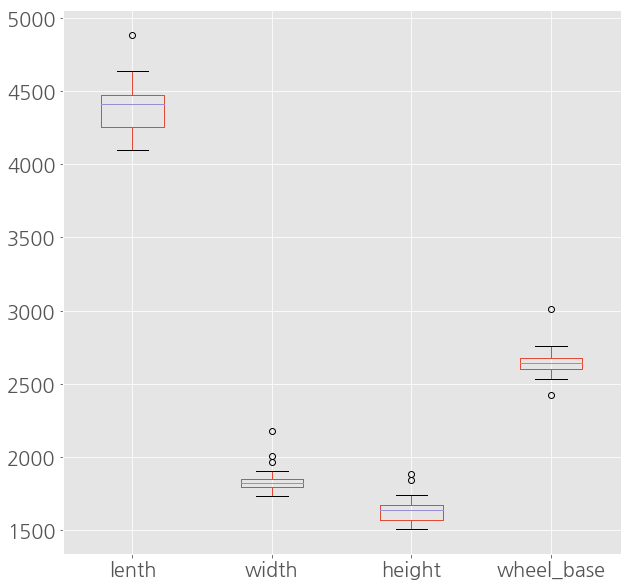

In [33]:
plt.figure(figsize=(10,10),)

feature.iloc[:,:-1].boxplot()

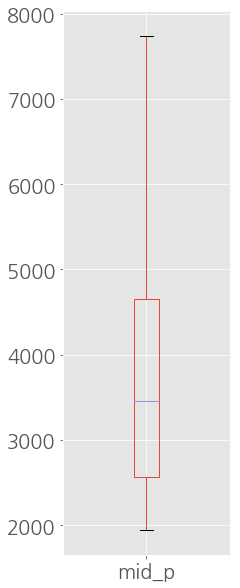

In [36]:
plt.figure(figsize=(3,10),)

feature.iloc[:,-1:].boxplot()

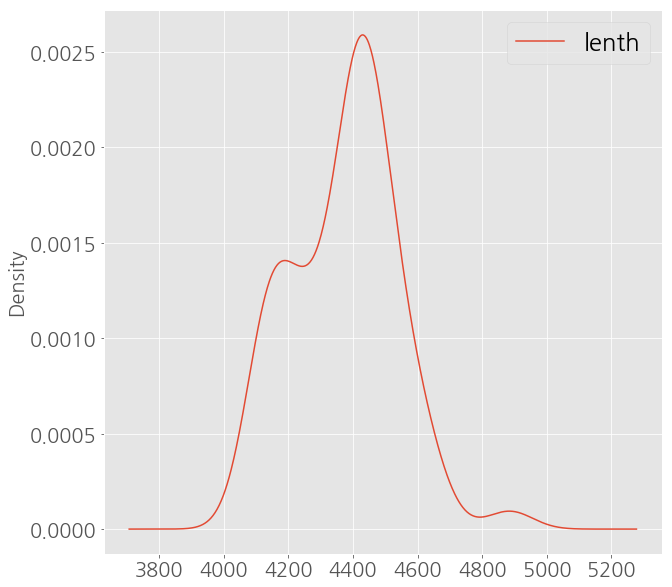

In [38]:
plt.figure(figsize=(10,10),)
feature.lenth.plot.density()
plt.legend()

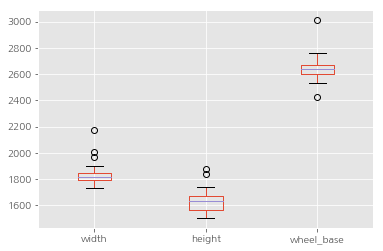

In [33]:
feature.iloc[:,1:-1].boxplot()

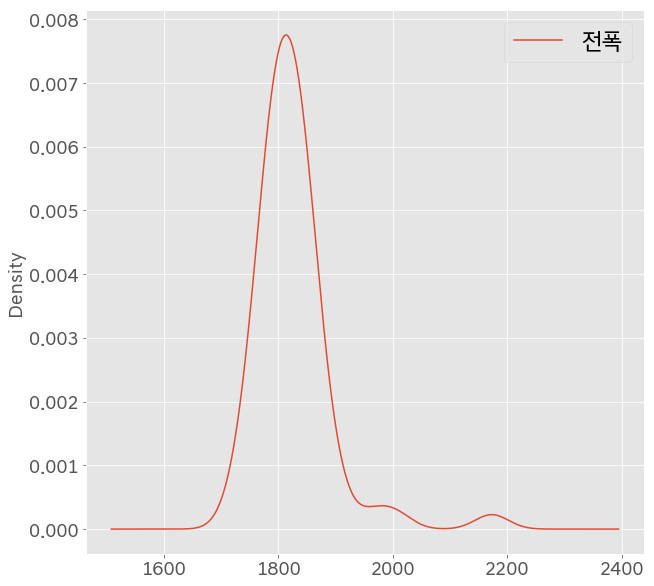

In [41]:
plt.figure(figsize=(10,10),)
feature.전폭.plot.density()
plt.legend()

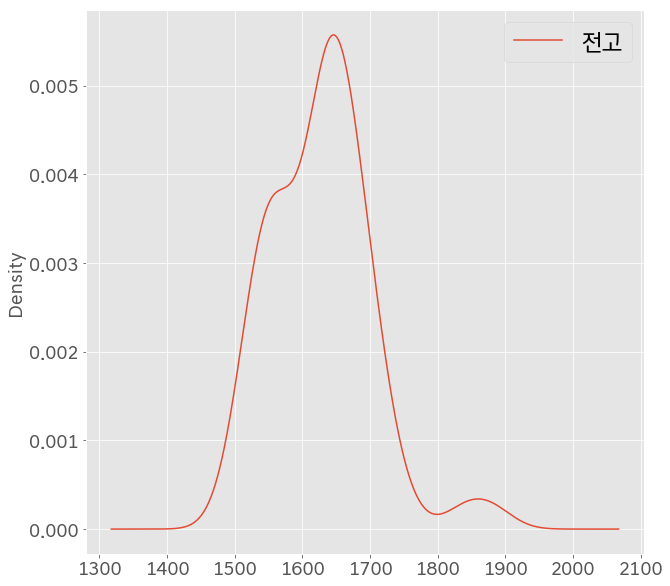

In [42]:
plt.figure(figsize=(10,10),)
feature.전고.plot.density()
plt.legend()

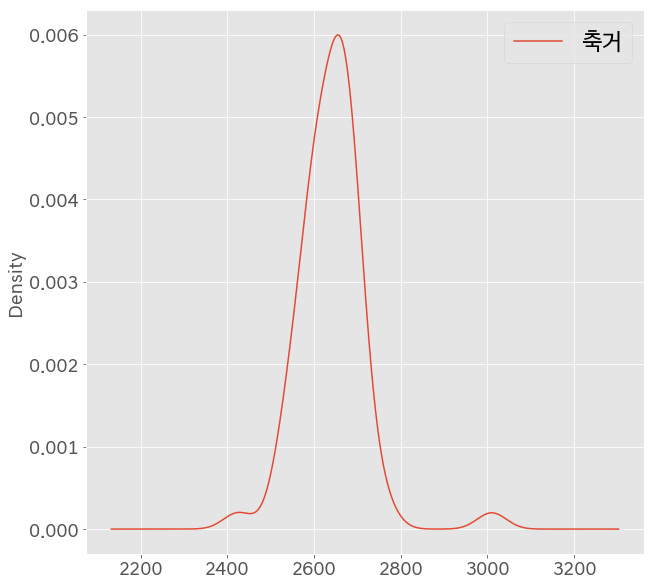

In [43]:
plt.figure(figsize=(10,10),)
feature.축거.plot.density()
plt.legend()

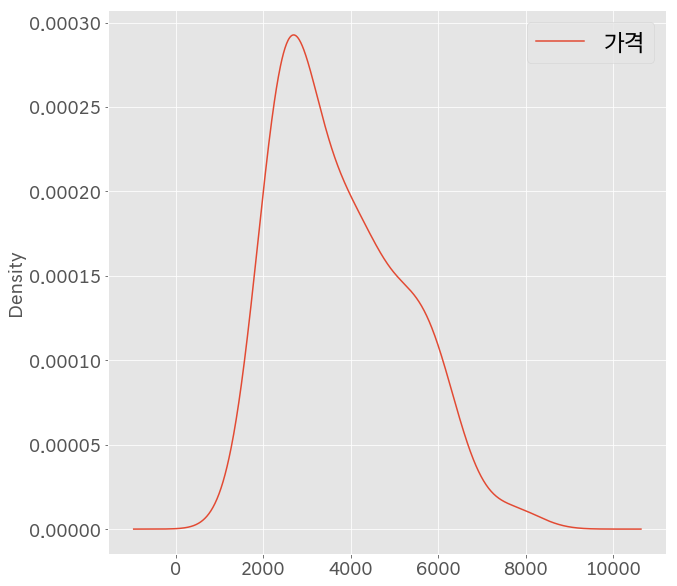

In [44]:
plt.figure(figsize=(10,10),)
feature.가격.plot.density()
plt.legend()

가격(mid_p) 포함 클러스터링

In [38]:
#가격 포함된 피쳐의 경우 스케일링

In [39]:
feature_scaled = pd.DataFrame(minmax_scale(feature),columns=['lenth', 'width', 'height', 'wheel_base', 'mid_p'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Distortion')

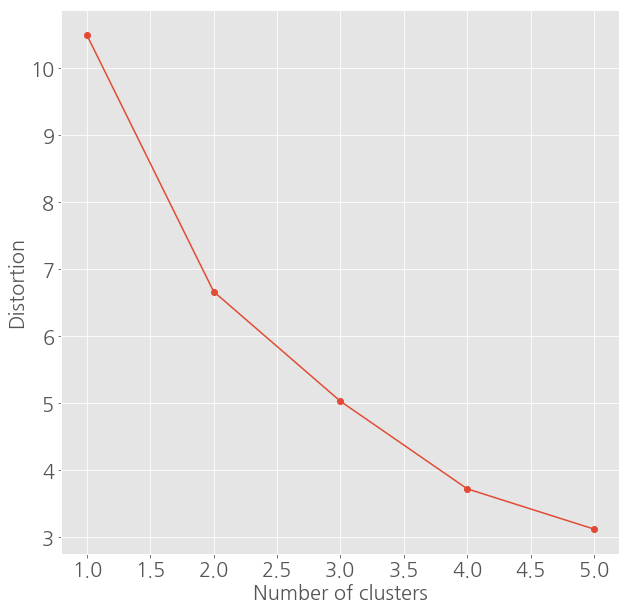

In [44]:
plt.figure(figsize=(10,10))
distortions = [] 
for k in range(1,6):
    km = KMeans(n_clusters = k,
               init='k-means++',
               n_init = 100,
               max_iter = 300,
               random_state=0)
    km.fit(feature_scaled)
    distortions.append(km.inertia_)

plt.plot(range(1,6), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

In [40]:
# create model and prediction
model_2 = KMeans(n_clusters = 2, init='k-means++',
                               n_init = 100, max_iter = 300,
                               random_state=0)
                 
model_3 = KMeans(n_clusters = 3, init='k-means++',
                               n_init = 100, max_iter = 300,
                               random_state=0)

model_4 = KMeans(n_clusters = 4, init='k-means++',
                               n_init = 100, max_iter = 300,
                               random_state=0)

model_2.fit(feature_scaled)
model_3.fit(feature_scaled)
model_4.fit(feature_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [41]:
predict_2 = pd.DataFrame(model_2.predict(feature_scaled))
predict_3 = pd.DataFrame(model_3.predict(feature_scaled))
predict_4 = pd.DataFrame(model_4.predict(feature_scaled))

predict_2.columns=['predict']
predict_3.columns=['predict']
predict_4.columns=['predict']

In [42]:
predict_2.predict = predict_2.predict.astype('category')
predict_3.predict = predict_3.predict.astype('category')
predict_4.predict = predict_4.predict.astype('category')

In [43]:
predict_4.describe(include = 'category')

,predict
count,60
unique,4
top,1
freq,24


In [44]:
predict_4.predict.value_counts()

1    24
0    20
2    13
3     3
Name: predict, dtype: int64

In [45]:
print("score for %d clusters:%.3f" % (2, silhouette_score(feature_scaled, model_2.labels_)))
print("score for %d clusters:%.3f" % (3, silhouette_score(feature_scaled, model_3.labels_)))
print("score for %d clusters:%.3f" % (4, silhouette_score(feature_scaled, model_4.labels_)))

score for 2 clusters:0.341
score for 3 clusters:0.337
score for 4 clusters:0.365


In [51]:
def plotSilhouette(X, y_km): #실루엣 스코어의 시각화
    plt.figure(figsize=(8,6))
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks=[]
    
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)
        
        plt.barh(range(y_ax_lower,y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)
        
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels)
    plt.ylabel('clusters')
    plt.xlabel('coefficient silhouette')
    plt.show()

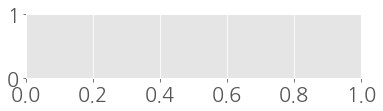

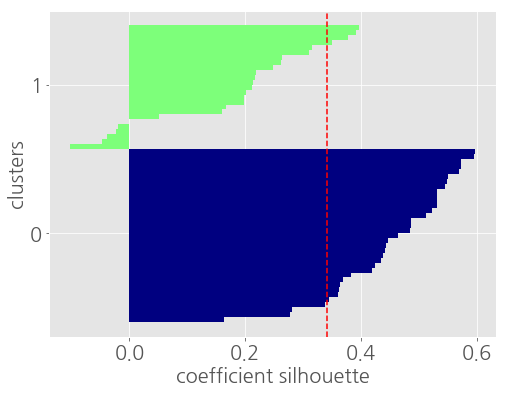

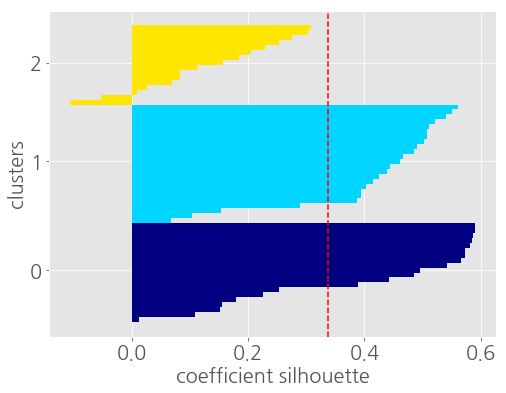

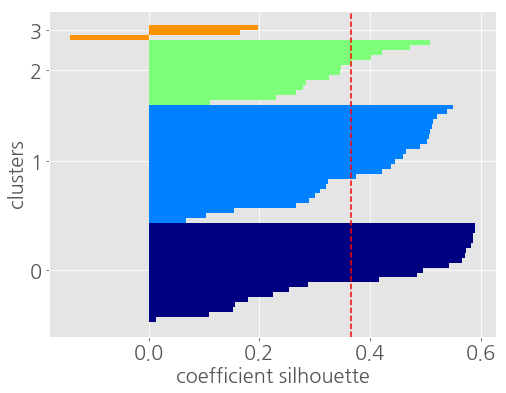

In [52]:
plt.subplot(3,1,1)
plotSilhouette(feature_scaled,predict_2.predict)
plotSilhouette(feature_scaled,predict_3.predict)
plotSilhouette(feature_scaled,predict_4.predict)

In [46]:
r_2 = pd.concat([feature_scaled,predict_2],axis=1)
r_3 = pd.concat([feature_scaled,predict_3],axis=1)
r_4 = pd.concat([feature_scaled,predict_4],axis=1)

C:\Users\Chankoo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Chankoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


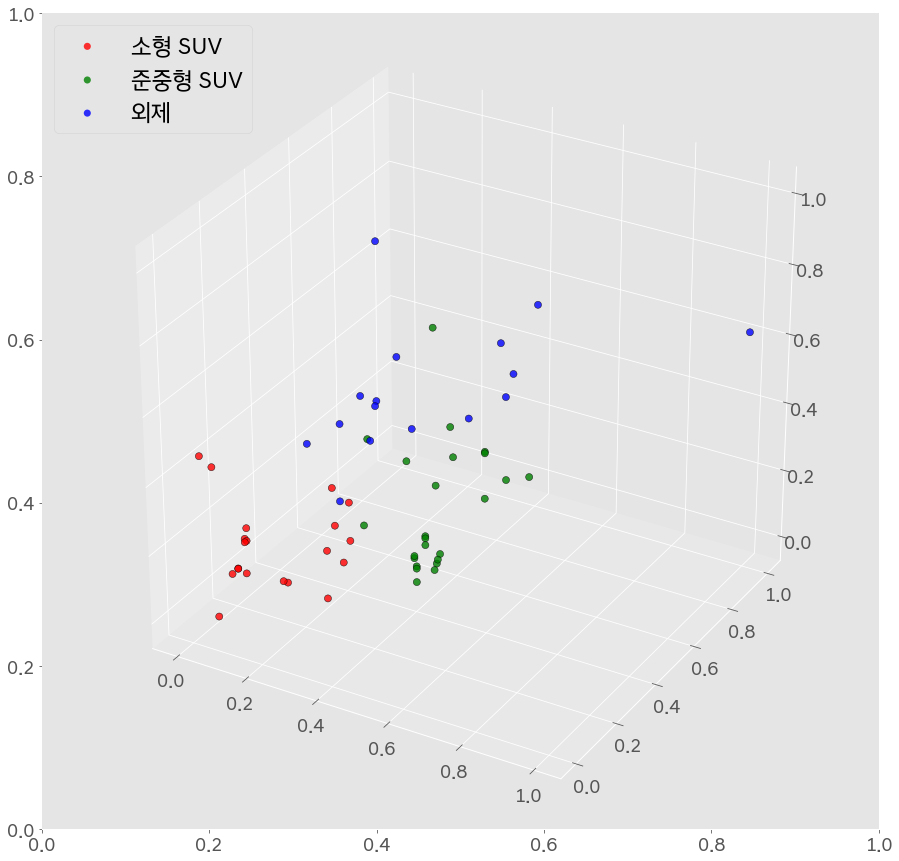

In [143]:
# r_3 = r_3.sort_values('predict')
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d
 
# lenths = np.array(r_3.lenth)
# heights = np.array(r_3.height)
# prices = np.array(r_3.mid_p)

# g0 = (lenths[:20], heights[:20], prices[:20])
# g1 = (lenths[20:44], heights[20:44], prices[20:44])
# g2 = (lenths[44:], heights[44:], prices[44:])
 
# ds =(g0,g1,g2)

# colors = ("red","green","blue")
# groups = ("소형 SUV", '준중형 SUV', '외제')
 
# # Create plot
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
# ax = fig.gca(projection='3d')
 
# for d, color, group in zip(ds, colors, groups):
#     x, y, z = d
#     ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=50, label=group)
 
# # plt.title('Matplot 3d scatter plot')
# plt.legend(loc=2)
# # plt.xlabel()
# plt.show()

In [69]:
len(feature_base)

62

In [47]:
feature_scaled = pd.DataFrame(minmax_scale(feature),columns=['lenth', 'width', 'height', 'wheel_base', 'mid_p'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.
  """Entry point for launching an IPython kernel.


In [48]:
len(feature_scaled)

60

In [49]:
# r_3
feature_model = pd.concat((feature_base.dropna().reset_index().model,feature_scaled),axis=1).sort_values(['lenth','mid_p'])

In [50]:
model_title = data[pd.Index(map(lambda x:not x,data[['model','title']].duplicated()))][['model','title']]

In [51]:

pd.merge(feature_model,model_title,on='model')

,model,lenth,width,height,wheel_base,mid_p,title
0,2445,0.000000,0.133183,0.104000,0.290598,0.389497,컨트리맨(R60)
1,3088,0.011465,0.126411,0.034667,0.292308,0.460205,페이스맨(R61)
2,3507,0.031847,0.112867,0.160000,0.307692,0.070708,QM3
3,3080,0.031847,0.112867,0.160000,0.307692,0.071743,QM3
4,3235,0.044586,0.079007,0.173333,0.179487,0.146331,뉴 쥬크
5,3115,0.044586,0.079007,0.173333,0.179487,0.156678,쥬크
6,3471,0.050955,0.067720,0.040000,0.264957,0.000000,스토닉
7,3269,0.076433,0.000000,0.066667,0.290598,0.120031,C4 Cactus
8,3135,0.076433,0.022573,0.133333,0.196581,0.181685,2008
9,3457,0.076433,0.022573,0.133333,0.196581,0.219195,2008


Text(0, 0.5, '전장')

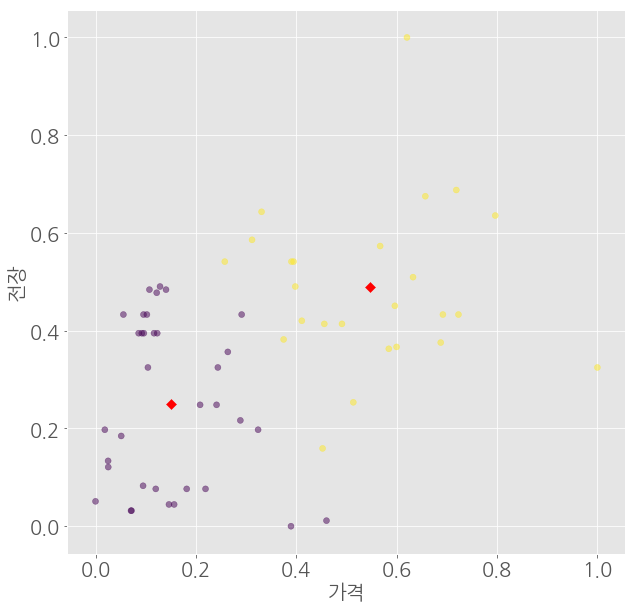

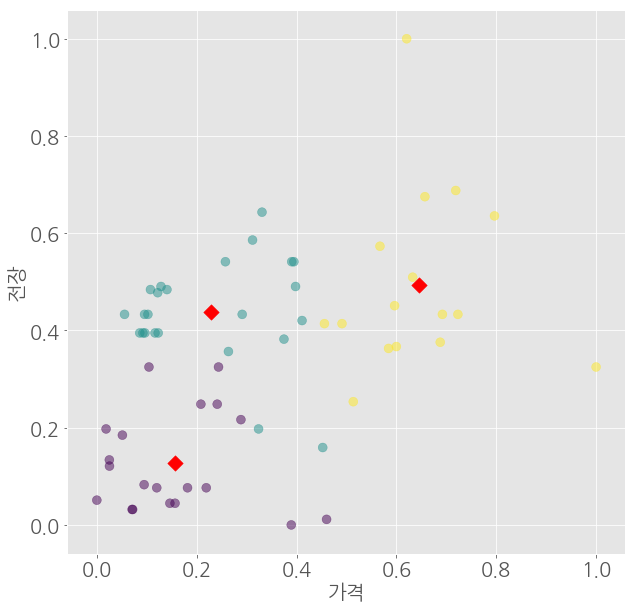

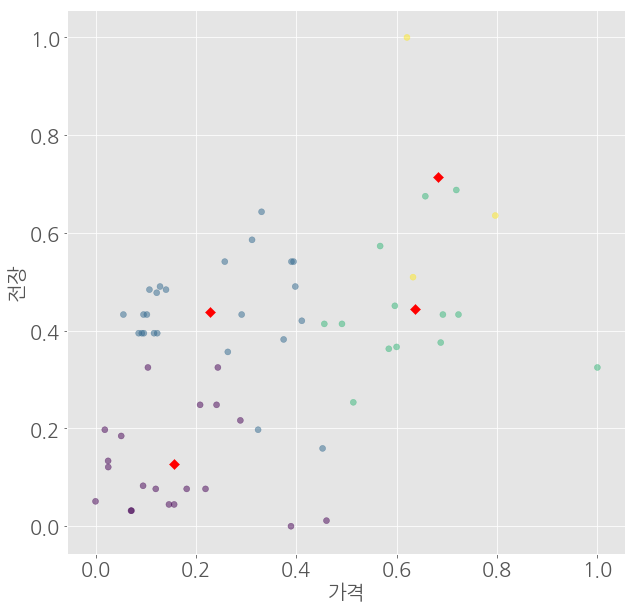

In [52]:
plt.figure(0,figsize=(10,10))
plt.scatter(r_2['mid_p'],r_2['lenth'],c=r_2['predict'],alpha=0.5)
centers = pd.DataFrame(model_2.cluster_centers_,columns=['lenth','width','height','wheel_base','mid_p'])
center_x = centers['mid_p']
center_y = centers['lenth']
plt.scatter(center_x,center_y,s=50,marker='D',c='r')
plt.xlabel('가격')
plt.ylabel('전장')

plt.figure(1,figsize=(10,10))
plt.scatter(r_3['mid_p'],r_3['lenth'],c=r_3['predict'],alpha=0.5,s=80)
centers = pd.DataFrame(model_3.cluster_centers_,columns=['lenth','width','height','wheel_base','mid_p'])
center_x = centers['mid_p']
center_y = centers['lenth']
plt.scatter(center_x,center_y,s=120,marker='D',c='r')
plt.xlim
plt.xlabel('가격')
plt.ylabel('전장')

plt.figure(2,figsize=(10,10))
plt.scatter(r_4['mid_p'],r_4['lenth'],c=r_4['predict'],alpha=0.5)
centers = pd.DataFrame(model_4.cluster_centers_,columns=['lenth','width','height','wheel_base','mid_p'])
center_x = centers['mid_p']
center_y = centers['lenth']
plt.scatter(center_x,center_y,s=50,marker='D',c='r')
plt.xlabel('가격')
plt.ylabel('전장')

In [51]:
model = model_3
r = r_3

In [52]:
model.cluster_centers_

array([[0.12636943, 0.10383747, 0.18493333, 0.28854701, 0.15587221],
       [0.4376327 , 0.2285553 , 0.44111111, 0.36574074, 0.22777083],
       [0.49442675, 0.33789503, 0.33      , 0.47008547, 0.64609382]])

In [93]:
model_to_concat = feature_base.dropna().reset_index(drop=True).model

In [94]:
res = pd.concat([model_to_concat,r],axis=1)

NameError: name 'r' is not defined

In [95]:
res.model = res.model.astype('str')

NameError: name 'res' is not defined

In [92]:
table = pd.merge(car_base.drop(columns='price_range'), res, on = 'model')

NameError: name 'res' is not defined

In [57]:
# table.sort_values('predict').to_excel('RU2_seg_detail.xlsx',encoding='utf-8')

In [58]:
hk_index = pd.concat([table[table.brand=='현대'],table[table.brand=='기아']],axis=0).dropna().index

In [59]:
table.loc[hk_index].sort_values('predict')

,model,brand,seg,title,lenth,width,height,wheel_base,mid_p,predict
45,3445,현대,소형SUV,코나,0.082803,0.158014,0.120000,0.299145,0.094766,0
36,3320,기아,소형SUV,니로 저공해2종,0.324841,0.169300,0.106667,0.470085,0.104424,0
44,3469,기아,소형SUV,니로 플러그인 하이브리드 저공해2종,0.324841,0.169300,0.106667,0.470085,0.243770,0
46,3471,기아,소형SUV,스토닉,0.050955,0.067720,0.040000,0.264957,0.000000,0
1,2100,현대,소형SUV,투싼 ix(LM),0.394904,0.203160,0.400000,0.367521,0.092265,1
15,3084,현대,소형SUV,뉴 투싼 ix(LM),0.394904,0.203160,0.400000,0.367521,0.085971,1
28,3250,현대,소형SUV,올 뉴 투싼(TL),0.477707,0.270880,0.373333,0.418803,0.121928,1
55,3567,현대,소형SUV,투싼,0.484076,0.270880,0.373333,0.418803,0.140467,1
0,2115,기아,소형SUV,스포티지 R(SL),0.433121,0.282167,0.346667,0.367521,0.102354,1
17,3103,기아,소형SUV,더 뉴 스포티지 R(SL),0.433121,0.282167,0.346667,0.367521,0.095628,1


In [60]:
table.drop(index=hk_index).sort_values('predict')

,model,brand,seg,title,lenth,width,height,wheel_base,mid_p,predict
27,3154,쌍용,소형SUV,티볼리(X100),0.121019,0.146727,0.226667,0.299145,0.025351,0
24,3135,푸조,소형SUV,2008,0.076433,0.022573,0.133333,0.196581,0.181685,0
35,3234,피아트,소형SUV,500X,0.216561,0.146727,0.306667,0.247863,0.288609,0
20,3080,르노삼성,소형SUV,QM3,0.031847,0.112867,0.160000,0.307692,0.071743,0
19,3115,닛산,소형SUV,쥬크,0.044586,0.079007,0.173333,0.179487,0.156678,0
37,3330,혼다,소형SUV,HR-V,0.248408,0.090293,0.266667,0.316239,0.208416,0
16,3088,미니,소형SUV,페이스맨(R61),0.011465,0.126411,0.034667,0.292308,0.460205,0
14,3054,쉐보레,소형SUV,트랙스,0.184713,0.101580,0.440000,0.222222,0.051220,0
12,2662,미쓰비시,소형SUV,RVR(3세대),0.248408,0.090293,0.333333,0.418803,0.241183,0
38,3269,시트로엥,소형SUV,C4 Cactus,0.076433,0.000000,0.066667,0.290598,0.120031,0


원래 scale대로 찍어보자

In [53]:
model_title = data[pd.Index(map(lambda x:not x,data[['model','title']].duplicated()))][['model','title']]

In [55]:
feature_base = data[['model','lenth','width','height','wheel_base','mid_p']] # 학습위한 피쳐 추출
feature_base.columns = pd.Index(['model', '전장', '전폭', '전고', '축거', '가격'], dtype='object')
feature_base = feature_base[feature_base.duplicated(subset=['model'],keep='first')==False] # 모델id 기준으로 중복 row 제거
feature_base.reset_index(drop=True, inplace=True)

In [57]:
feature_model_0 = pd.merge(feature_base,model_title,on='model')
feature_model_0 = feature_model_0.dropna().reset_index()
feature_model_0 = pd.concat((feature_model_0,r_3['predict']),axis=1)

In [82]:
feature_model_0.sort_values(['전장','가격']).to_excel('cluster_plotting.xlsx',encoding='utf-8')

Text(0, 0.5, '전장')

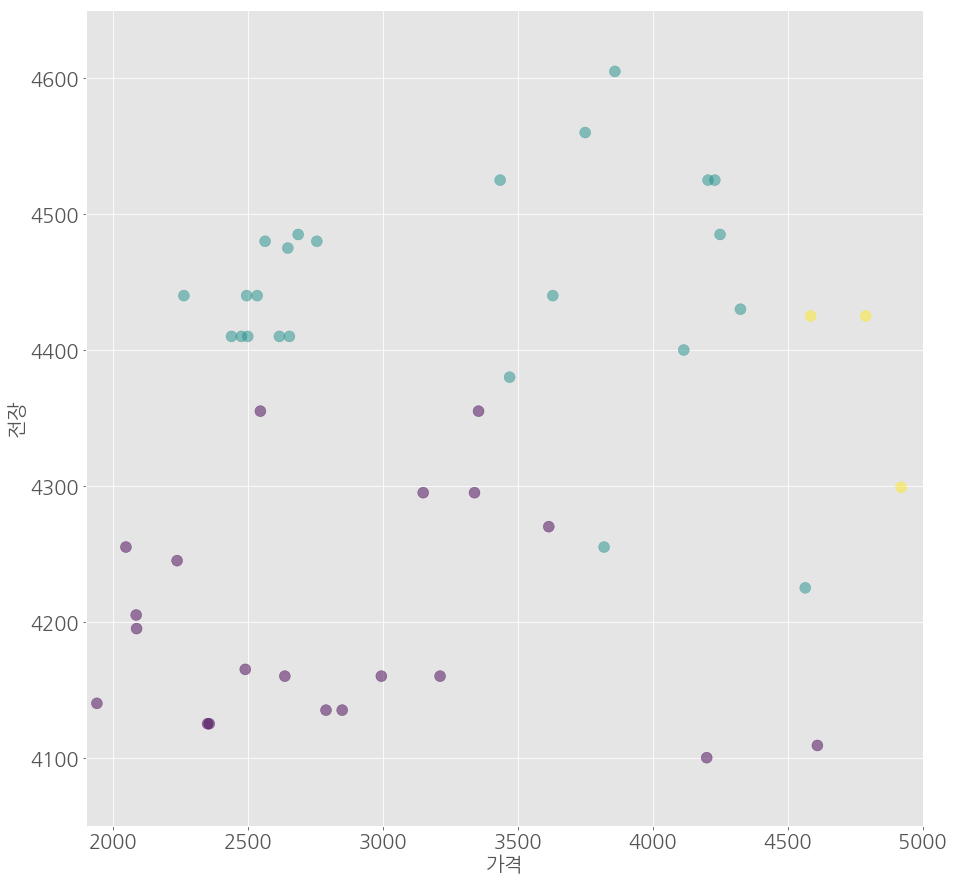

In [80]:
plt.figure(1,figsize=(15,15))
plt.scatter(feature_model_0['가격'],feature_model_0['전장'],c=feature_model_0['predict'],alpha=0.5,s=120)
# centers = pd.DataFrame(model_3.cluster_centers_,columns=['lenth','width','height','wheel_base','mid_p'])
# center_x = centers['mid_p']
# center_y = centers['lenth']
# plt.scatter(center_x,center_y,s=120,marker='D',c='r')
plt.xlim((1900,5000))
plt.ylim((4050,4650))
plt.xlabel('가격')
plt.ylabel('전장')

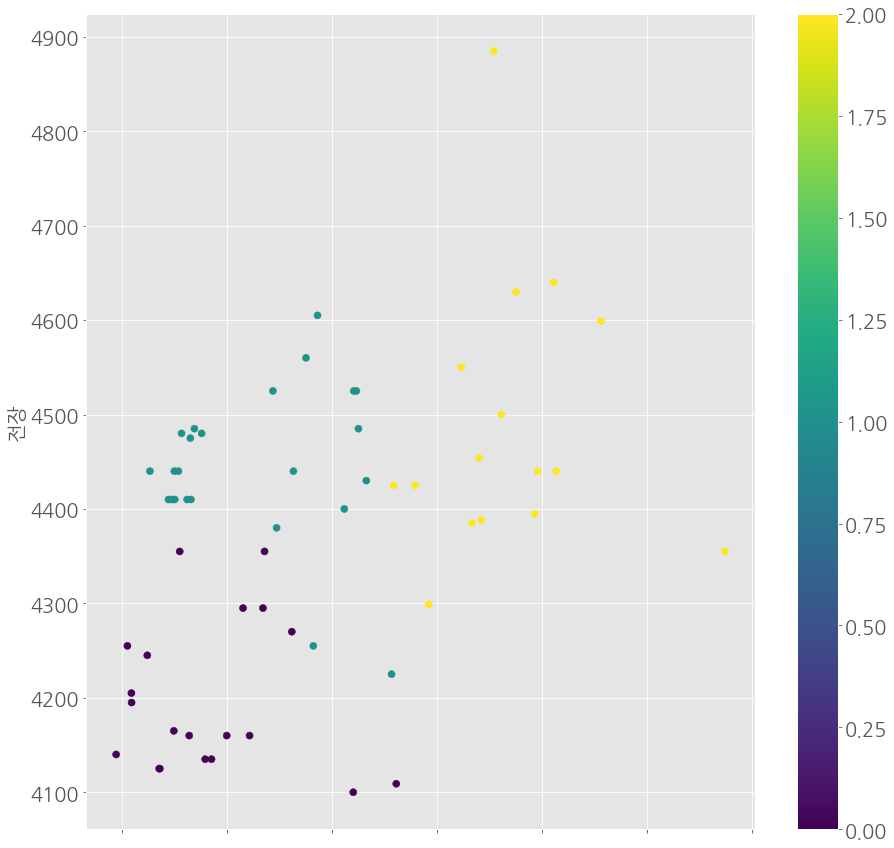

In [66]:
feature_model_0.plot.scatter('가격','전장',c=feature_model_0.predict.astype('int16'),colormap='viridis',figsize=(15,15),s=50)

In [91]:
table[['model','predict']]

NameError: name 'table' is not defined

세그먼트별 판매실적을 보자

In [96]:
car_sub_sold = pd.read_csv('monthly_sub_utf.csv').drop(columns='Unnamed: 0')

In [100]:
cluster = pd.read_excel('cluster_plotting.xlsx',encoding='utf-8')

In [104]:
dsl_gsl = pd.merge(cluster,car_sub_sold,on='model')[['model','predict','seg','YM','title_y','sub_title','sub_sold']]

In [106]:
dsl_gsl.to_excel('dsl_gsl.xlsx',encoding='utf-8')

In [61]:
car_sold = pd.read_csv('monthly_utf.csv').drop(columns='Unnamed: 0')

In [62]:
car_sold = car_sold[car_sold.seg == 'RU2'][['model','YM','sold']]

In [63]:
car_sold.model = car_sold.model.astype('str')
car_sold.YM = car_sold.YM.astype('str')

In [64]:
car_sold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1748 entries, 98 to 15787
Data columns (total 3 columns):
model    1748 non-null object
YM       1748 non-null object
sold     1748 non-null int64
dtypes: int64(1), object(2)
memory usage: 54.6+ KB


In [65]:
car_sold = pd.merge(car_sold,table[['brand','title','model','predict']],on='model')

In [66]:
car_sold_dur = car_sold[car_sold.YM > '201806']

In [67]:
brand_sold = car_sold_dur.groupby(['brand']).sum()[['sold']].dropna()

In [68]:
# 폰트설정

In [69]:
print ('버전: ', matplotlib.__version__)
print ('설치위치: ', matplotlib.__file__)
print ('설정: ', matplotlib.get_configdir())
print ('캐시: ', matplotlib.get_cachedir())

버전:  2.1.2
설치위치:  C:\Users\Chankoo\Anaconda3\lib\site-packages\matplotlib\__init__.py
설정:  C:\Users\Chankoo\.matplotlib
캐시:  C:\Users\Chankoo\.matplotlib


In [70]:
plt.rcParams["font.family"] = 'NanumGothic'

In [71]:
brand_sold = brand_sold.sort_values('sold',ascending=False)

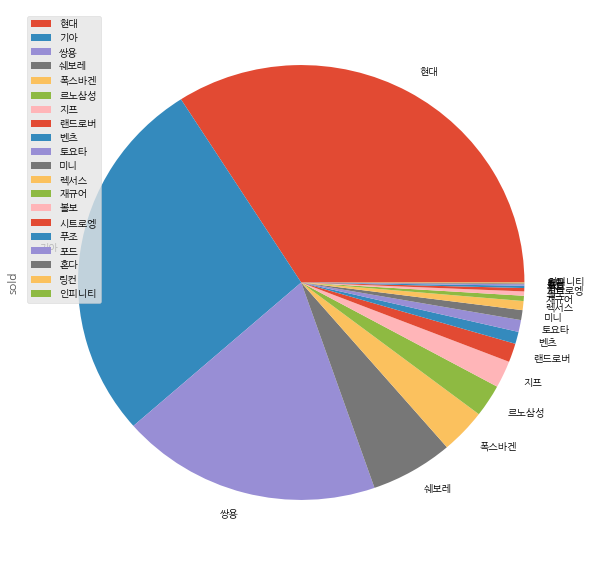

In [72]:
brand_sold.plot.pie(y='sold',figsize=(10,10),)

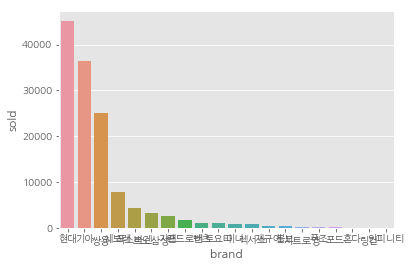

In [73]:
sns.barplot(data=brand_sold,y='sold',x=brand_sold.index)

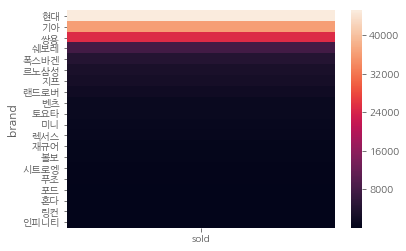

In [74]:
sns.heatmap(brand_sold,)

In [75]:
seg_brand_sold = car_sold_dur.groupby(['predict','brand']).sum()[['sold']].dropna()

In [76]:
# fm.get_fontconfig_fonts()
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows 
# font_name = fm.FontProperties(fname=font_location).get_name() 
# matplotlib.rc('font', family=font_name)

In [77]:
seg_brand_sold

sold
predict brand         
0       기아     16694.0
        르노삼성    3188.0
        쉐보레     7949.0
        시트로엥     328.0
        쌍용     23207.0
        푸조       228.0
        현대     19526.0
        혼다        92.0
1       기아     19649.0
        쌍용      1815.0
        지프      1618.0
        토요타     1171.0
        포드       141.0
        폭스바겐    4412.0
        현대     25638.0
2       랜드로버    1846.0
        렉서스      889.0
        링컨        56.0
        미니       977.0
        벤츠      1190.0
        볼보       422.0
        인피니티      22.0
        재규어      516.0
        지프      1044.0

seg 더 쪼개보자

In [22]:
table = pd.read_excel('RU2_seg_detail.xlsx',encoding='utf-8')

In [30]:
table2 = pd.concat((table.loc[table.predict==0],table.loc[table.predict==1]),axis=0)

In [31]:
feature_base = table2[['model','lenth','width','height','wheel_base','mid_p']] # 학습위한 피쳐 추출

In [32]:
feature = feature_base.drop(columns='model') # model 드랍

In [36]:
feature_scaled = pd.DataFrame(minmax_scale(feature),columns=['lenth', 'width', 'height', 'wheel_base', 'mid_p'],index=feature.index)

In [39]:
# create model and prediction
model_2 = KMeans(n_clusters = 2, init='k-means++',
                               n_init = 100, max_iter = 300,
                               random_state=0)
                 
model_3 = KMeans(n_clusters = 3, init='k-means++',
                               n_init = 100, max_iter = 300,
                               random_state=0)

model_4 = KMeans(n_clusters = 4, init='k-means++',
                               n_init = 100, max_iter = 300,
                               random_state=0)

model_2.fit(feature_scaled)
model_3.fit(feature_scaled)
model_4.fit(feature_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [40]:
predict_2 = pd.DataFrame(model_2.predict(feature_scaled))
predict_3 = pd.DataFrame(model_3.predict(feature_scaled))
predict_4 = pd.DataFrame(model_4.predict(feature_scaled))

predict_2.columns=['predict']
predict_3.columns=['predict']
predict_4.columns=['predict']

In [41]:
predict_2.predict = predict_2.predict.astype('category')
predict_3.predict = predict_3.predict.astype('category')
predict_4.predict = predict_4.predict.astype('category')

In [42]:
r_2 = pd.concat([feature_scaled,predict_2],axis=1)
r_3 = pd.concat([feature_scaled,predict_3],axis=1)
r_4 = pd.concat([feature_scaled,predict_4],axis=1)

Text(0,0.5,'전장')

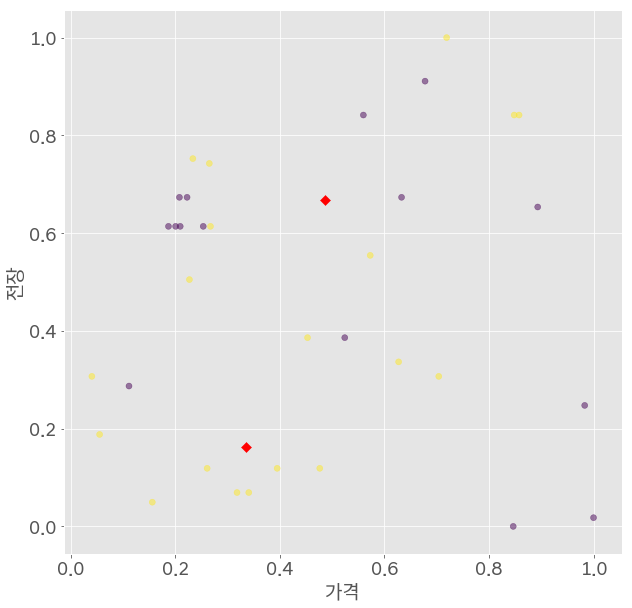

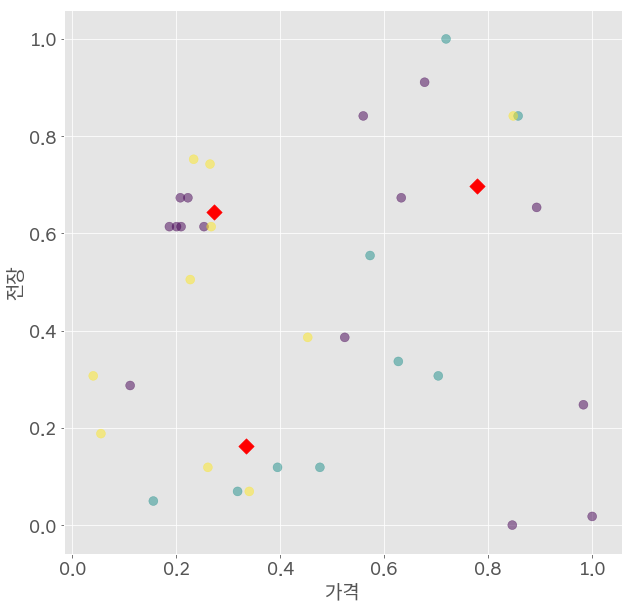

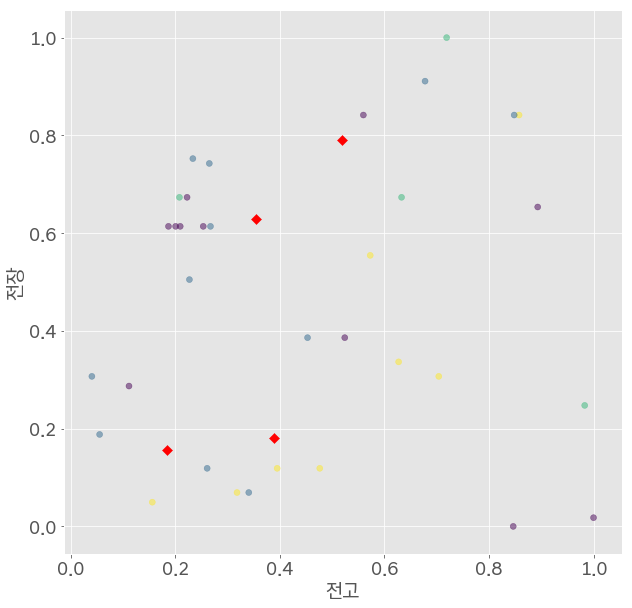

In [45]:
plt.figure(0,figsize=(10,10))
plt.scatter(r_2['mid_p'],r_2['lenth'],c=r_2['predict'],alpha=0.5)
centers = pd.DataFrame(model_2.cluster_centers_,columns=['lenth','width','height','wheel_base','mid_p'])
center_x = centers['mid_p']
center_y = centers['lenth']
plt.scatter(center_x,center_y,s=50,marker='D',c='r')
plt.xlabel('가격')
plt.ylabel('전장')

plt.figure(1,figsize=(10,10))
plt.scatter(r_3['mid_p'],r_3['lenth'],c=r_3['predict'],alpha=0.5,s=80)
centers = pd.DataFrame(model_3.cluster_centers_,columns=['lenth','width','height','wheel_base','mid_p'])
center_x = centers['mid_p']
center_y = centers['lenth']
plt.scatter(center_x,center_y,s=120,marker='D',c='r')
plt.xlabel('가격')
plt.ylabel('전장')

plt.figure(2,figsize=(10,10))
plt.scatter(r_4['mid_p'],r_4['lenth'],c=r_4['predict'],alpha=0.5)
centers = pd.DataFrame(model_4.cluster_centers_,columns=['lenth','width','height','wheel_base','mid_p'])
center_x = centers['height']
center_y = centers['lenth']
plt.scatter(center_x,center_y,s=50,marker='D',c='r')
plt.xlabel('전고')
plt.ylabel('전장')

가격 미포함 클러스터링

In [78]:
feature_base2 = feature_base.drop(columns='mid_p')
feature2 = feature.drop(columns='mid_p')

Text(0,0.5,'Distortion')

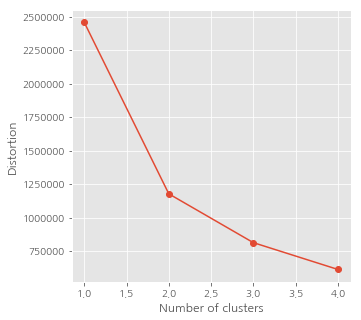

In [79]:
plt.figure(figsize=(5,5))
distortions = [] 
for k in range(1,5):
    km = KMeans(n_clusters = k,
               init='k-means++',
               n_init = 100,
               max_iter = 300,
               random_state=0)
    km.fit(feature2)
    distortions.append(km.inertia_)

plt.plot(range(1,5), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

In [105]:
# create model and prediction

model2 = KMeans(n_clusters = 3,
               init='k-means++',
               n_init = 100,
               max_iter = 300,
               random_state=0)

model2.fit(feature2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [106]:
predict2 = pd.DataFrame(model2.predict(feature2))

predict2.columns=['predict']

In [107]:
predict2.predict = predict2.predict.astype('category')

In [108]:
predict2.describe(include = 'category')

,predict
count,60
unique,3
top,0
freq,37


In [109]:
predict2.predict.value_counts()

0    37
1    21
2     2
Name: predict, dtype: int64

In [110]:
print("score for %d clusters:%.3f" % (2, silhouette_score(feature2, model2.labels_)))

score for 2 clusters:0.514


In [111]:
def plotSilhouette(X, y_km): #실루엣 스코어의 시각화
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks=[]
    
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)
        
        plt.barh(range(y_ax_lower,y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)
        
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels)
    plt.ylabel('clusters')
    plt.xlabel('coefficient silhouette')
    plt.show()

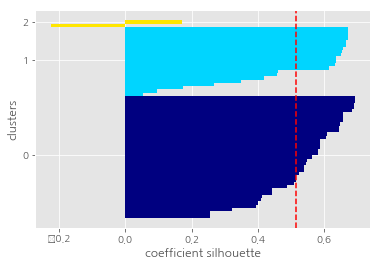

In [112]:
plotSilhouette(feature2,predict2.predict)

In [113]:
r2 = pd.concat([feature2,predict2],axis=1)


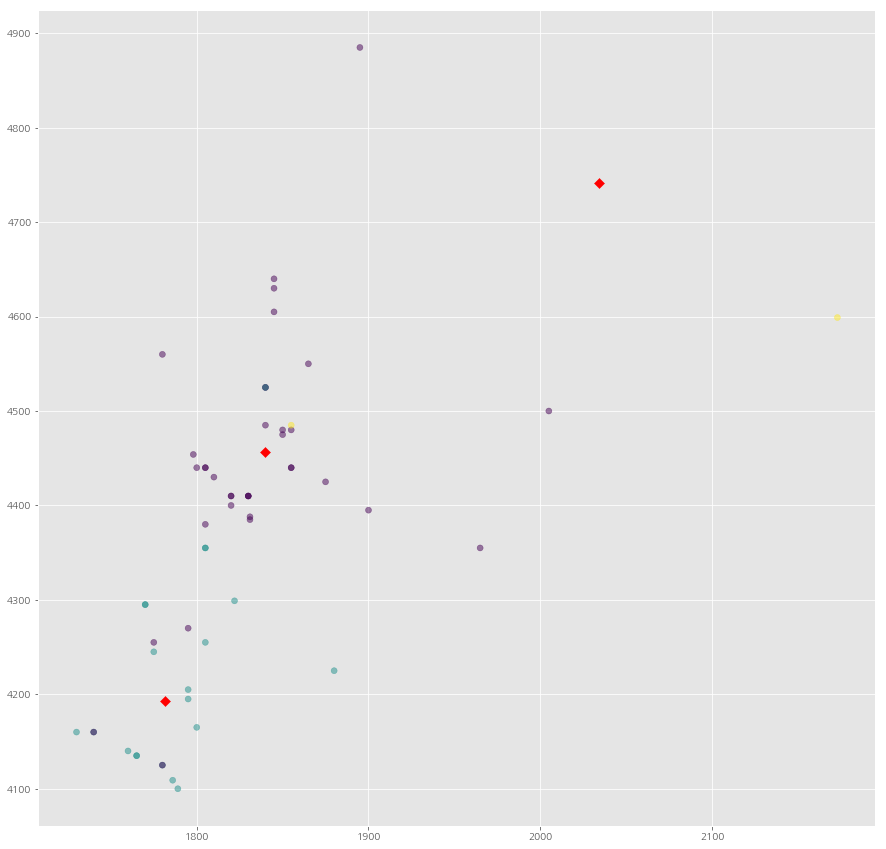

In [114]:
plt.figure(figsize=(15,15))

plt.scatter(r2['width'],r2['lenth'],c=r2['predict'],alpha=0.5)

centers = pd.DataFrame(model2.cluster_centers_,columns=['lenth','width','height','wheel_base'])

center_x = centers['width']

center_y = centers['lenth']

plt.scatter(center_x,center_y,s=50,marker='D',c='r')

plt.show()


In [115]:
res2 = pd.concat([feature2,predict2],axis=1)

In [116]:
res2= pd.concat([feature_base2[['model']],res2],axis=1)

In [117]:
table2 = pd.merge(car_base.drop(columns='price_range'), res2, on = 'model')

1== 소형

0== 중소형

In [118]:
hk_index2 = pd.concat([table2[table2.brand=='현대'],table2[table2.brand=='기아']],axis=0).dropna().index

In [119]:
table2.loc[hk_index2]

,model,brand,seg,title,lenth,width,height,wheel_base,predict
1,2100,현대,소형SUV,투싼 ix(LM),4410.0,1820.0,1655.0,2640.0,0
15,3084,현대,소형SUV,뉴 투싼 ix(LM),4410.0,1820.0,1655.0,2640.0,0
28,3250,현대,소형SUV,올 뉴 투싼(TL),4475.0,1850.0,1645.0,2670.0,0
46,3445,현대,소형SUV,코나,4165.0,1800.0,1550.0,2600.0,1
56,3567,현대,소형SUV,투싼,4480.0,1850.0,1645.0,2670.0,0
0,2115,기아,소형SUV,스포티지 R(SL),4440.0,1855.0,1635.0,2640.0,0
17,3103,기아,소형SUV,더 뉴 스포티지 R(SL),4440.0,1855.0,1635.0,2640.0,0
31,3298,기아,소형SUV,더 SUV 스포티지(QL),4480.0,1855.0,1635.0,2670.0,0
37,3320,기아,소형SUV,니로 저공해2종,4355.0,1805.0,1545.0,2700.0,1
45,3469,기아,소형SUV,니로 플러그인 하이브리드 저공해2종,4355.0,1805.0,1545.0,2700.0,1


In [121]:
table2.drop(index=hk_index)[table2.predict==0]

C:\Users\Chankoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,model,brand,seg,title,lenth,width,height,wheel_base,predict
2,2146,쌍용,소형SUV,코란도 C(C200),4410.0,1830.0,1675.0,2650.0,0
4,2337,폭스바겐,소형SUV,티구안(5N),4430.0,1810.0,1705.0,2604.0,0
6,2471,지프,소형SUV,뉴 컴패스(MK49),4440.0,1800.0,1670.0,2640.0,0
7,2579,랜드로버,소형SUV,레인지로버 이보크(L538),4355.0,1965.0,1635.0,2660.0,0
8,2368,BMW,소형SUV,X1(E84),4454.0,1798.0,1545.0,2760.0,0
9,2665,스바루,소형SUV,포레스터(3세대),4560.0,1780.0,1700.0,2615.0,0
10,2574,랜드로버,소형SUV,프리랜더2(L359),4500.0,2005.0,1740.0,2660.0,0
11,2423,아우디,소형SUV,Q3(8U),4385.0,1831.0,1608.0,2603.0,0
13,2485,포드,소형SUV,이스케이프(3세대),4525.0,1840.0,1690.0,2690.0,0
18,3105,쌍용,소형SUV,뉴 코란도 C(C200),4410.0,1830.0,1675.0,2650.0,0


In [122]:
table2.drop(index=hk_index)[table2.predict==1]

C:\Users\Chankoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,model,brand,seg,title,lenth,width,height,wheel_base,predict
3,2445,미니,소형SUV,컨트리맨(R60),4100.0,1789.0,1544.0,2595.0,1
5,2468,지프,소형SUV,랭글러(JK),4225.0,1880.0,1840.0,2425.0,1
12,2662,미쓰비시,소형SUV,RVR(3세대),4295.0,1770.0,1630.0,2670.0,1
14,3054,쉐보레,소형SUV,트랙스,4245.0,1775.0,1670.0,2555.0,1
16,3088,미니,소형SUV,페이스맨(R61),4109.0,1786.0,1518.0,2596.0,1
19,3115,닛산,소형SUV,쥬크,4135.0,1765.0,1570.0,2530.0,1
20,3080,르노삼성,소형SUV,QM3,4125.0,1780.0,1565.0,2605.0,1
24,3135,푸조,소형SUV,2008,4160.0,1740.0,1555.0,2540.0,1
26,3235,닛산,소형SUV,뉴 쥬크,4135.0,1765.0,1570.0,2530.0,1
27,3154,쌍용,소형SUV,티볼리(X100),4195.0,1795.0,1590.0,2600.0,1
